In [1]:
import os
import pydub 
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
#import fastparquet
from sklearn.preprocessing import StandardScaler
songDirectories = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
train_songs = pd.DataFrame()
test_songs = pd.DataFrame()
train_labels_list = []
test_labels_list = []

In [2]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [3]:
df = pd.DataFrame()
songDirectories = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
print(songDirectories)
partSize = 40000
compressionRate = 20
for i in range (len(songDirectories)):
    songs = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[i])
    for j in tqdm(range(len(songs))):
        sr, x = read('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[i]+'/'+songs[j])
        song = pd.DataFrame(x)
        numParts = song.shape[0] // partSize
        #if(song.shape[0] <= partSize*numParts):
        #    continue
        tempdf = pd.DataFrame()
        for k in range(numParts):
            tempSong = pd.DataFrame(((song.truncate(before = 1+(k*partSize),after = ((k+1)*partSize)))).to_numpy())#.flatten('C'))
            tempSong = (tempSong.groupby(np.arange(len(tempSong))//compressionRate).mean()).transpose() #compresses song - changes 100,000 array into len 100,000/compressionRate, using mean on every section len compressionRate
            tempdf = pd.concat([tempdf,tempSong])
            tempSong = None
        df = pd.concat([df,tempdf])
    df = df.reset_index(drop=True)
    df.columns = df.columns.astype(str)
    df.to_feather((str(songDirectories[i])+".feather"))
    df = None
    df = pd.DataFrame()
    


['Alternative', 'Classical', 'Country', 'EDM&Dance', 'Hyperpop', 'Jazz', 'Pop', 'R&B', 'Rap', 'Rock']


100%|██████████| 602/602 [15:43<00:00,  1.57s/it]


In [8]:
df = pd.DataFrame()
songDirectories = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
print(songDirectories)
#partSize = 8000000 
compressionRate = 1000
numParts = 30
for i in range (len(songDirectories)):
    songs = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[i])
    for j in tqdm(range(len(songs))):
        sr, x = read('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[i]+'/'+songs[j])
        song = pd.DataFrame(x)
        tempdf = pd.DataFrame()
        for k in range(numParts):
            tempSong = pd.DataFrame(((song.truncate(before = 1+(k*len(song)/numParts),after = ((k+1)*len(song)/numParts)))).to_numpy())#.flatten('C'))
            #tempSong = pd.DataFrame(song.to_numpy())
            #print(len(tempSong))
            #if(len(tempSong)):
            #    continue
            
            tempSong = (tempSong.groupby(np.arange(len(tempSong))//(len(tempSong)/10000)).mean()).transpose() #compresses song - changes 100,000 array into len 100,000/compressionRate, using mean on every section len compressionRate
            tempdf = pd.concat([tempdf,tempSong])
            tempSong = None
        
        df = pd.concat([df,tempdf])
        #print(df.shape)
    df = df.reset_index(drop=True)
    df.to_hdf((str(songDirectories[i])+".h5"), key='df', mode='w',nan_rep=0,format='fixed')
    df = None
    df = pd.DataFrame()
    


['Alternative', 'Classical', 'Country', 'EDM&Dance', 'Hyperpop', 'Jazz', 'Pop', 'R&B', 'Rap', 'Rock']


100%|██████████| 602/602 [20:34<00:00,  2.05s/it]


In [5]:

scaler = StandardScaler()#MinMaxScaler(feature_range=(-1,1))
for i in tqdm(range(0,10)):
    scaler_data = pd.read_feather("training_data_v2/"+str(songDirectories[i])+".feather")
    scaler.partial_fit(scaler_data)
del scaler_data
for i in tqdm(range(0,10)):
    data = pd.read_feather("training_data_v2/"+str(songDirectories[i])+".feather")
    scaled_data = pd.DataFrame(scaler.transform(data))
    scaled_data.columns = scaled_data.columns.astype(str)
    scaled_data.to_feather(("scaled_data_v2/"+str(songDirectories[i])+"_scaled.feather"))
    del data
    del scaled_data


100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


In [3]:
test_songs_final = pd.DataFrame()
test_labels_list_final = []
for i in tqdm(range(0,10)):
    test_songs = pd.read_hdf("scaled_data/"+str(songDirectories[i])+"_scaled.feather", 'df',dtypes=np.float64)#pd.DataFrame(train_labels_list)
    test_songs = test_songs.tail(test_songs.shape[0]//6)
    #test_songs = pd.read_hdf("training_data_chunks/"+str(i)+".h5", 'df',dtypes=np.float64)
    #test_songs = test_songs.tail(12000)
    for j in range(test_songs.shape[0]):
        test_labels_list_final.append(i)
    test_songs_final = pd.concat([test_songs_final,test_songs])
    #test_labels_list_final = pd.concat([test_labels_list_final,test_labels])
    #test_songs_final = pd.concat([test_songs_final,test_songs])
    del test_songs
test_labels_list_final = pd.DataFrame(test_labels_list_final)
test_labels_list_final.to_feather('test_labels.feather')
test_songs_final.to_feather('test.feather')
#test_labels_list_final = tf.keras.utils.to_categorical(test_labels_list_final)
#test_labels_list_final = np.expand_dims(test_labels_list_final, 1)
#test_songs_final = x = np.expand_dims(test_songs_final, 1)


100%|██████████| 10/10 [00:55<00:00,  5.56s/it]


In [1]:
#model with binomial classification
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import gc
import pickle
songDirectories = ['R&B','Country']
train_songs = pd.DataFrame()
test_songs = pd.DataFrame()
train_labels = []
test_labels = []
for i in tqdm(range(0,2)):
    temp = pd.read_feather("scaled_data/"+str(songDirectories[i])+"_scaled.feather")
    train_temp = temp.head(temp.shape[0] - temp.shape[0]//6)
    test_temp = temp.tail(temp.shape[0]//6)
    for j in range(train_temp.shape[0]):
        train_labels.append(i)
    for j in range(test_temp.shape[0]):
        test_labels.append(i)
    train_songs = pd.concat([train_songs,train_temp])
    test_songs = pd.concat([test_songs,test_temp])
del temp,train_temp,test_temp
gc.collect(generation=2)
train_songs = train_songs.reset_index(drop=True)
test_songs = test_songs.reset_index(drop=True)
test_labels = tf.keras.utils.to_categorical(test_labels)
test_labels = np.expand_dims(test_labels, 1)
test_songs = np.expand_dims(test_songs, 1)
train_labels = tf.keras.utils.to_categorical(train_labels)
train_labels = np.expand_dims(train_labels, 1)
train_songs = np.expand_dims(train_songs, 1)

100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


In [2]:
print(train_songs.shape)#labels
print(train_labels.shape)
print(test_songs.shape)#labels
print(test_labels.shape)

(257263, 1, 4000)
(257263, 1, 2)
(51451, 1, 4000)
(51451, 1, 2)


In [3]:
model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units = 2000,input_shape=(1,4000), return_sequences=True),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.SimpleRNN(units = 1000, input_shape=(1,2000),return_sequences=True),
  tf.keras.layers.Dropout(0.4),
 # tf.keras.layers.Dropout(0.45),
  #tf.keras.layers.GaussianNoise(0.05),
  #tf.keras.layers.Dense(1024, activation=tf.nn.relu),
  #tf.keras.layers.Dropout(0.45),
  #tf.keras.layers.ActivityRegularization(l1=0.0005,l2=0.0),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)
  ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [4]:
history = model.fit(train_songs,train_labels,epochs=20,validation_data = (test_songs,test_labels),batch_size=512)

Epoch 1/20
503/503 [==============================] - 12s 19ms/step - loss: 0.7223 - accuracy: 0.5957 - val_loss: 0.6118 - val_accuracy: 0.7059
Epoch 2/20
503/503 [==============================] - 8s 15ms/step - loss: 0.6545 - accuracy: 0.6592 - val_loss: 0.5909 - val_accuracy: 0.7200
Epoch 3/20
503/503 [==============================] - 8s 15ms/step - loss: 0.6151 - accuracy: 0.6927 - val_loss: 0.5880 - val_accuracy: 0.7161
Epoch 4/20
503/503 [==============================] - 8s 15ms/step - loss: 0.5847 - accuracy: 0.7147 - val_loss: 0.5905 - val_accuracy: 0.7144
Epoch 5/20
503/503 [==============================] - 8s 15ms/step - loss: 0.5584 - accuracy: 0.7329 - val_loss: 0.5908 - val_accuracy: 0.7163
Epoch 6/20
503/503 [==============================] - 8s 15ms/step - loss: 0.5314 - accuracy: 0.7492 - val_loss: 0.5973 - val_accuracy: 0.7172
Epoch 7/20
503/503 [==============================] - 8s 15ms/step - loss: 0.5090 - accuracy: 0.7629 - val_loss: 0.6065 - val_accuracy: 0.714

In [16]:
#del train_songs,test_songs,test_labels,train_labels
gc.collect(generation=2)

8

In [8]:
np.save('model_results/my_history.npy',history)

In [9]:
history=np.load('model_results/my_history.npy',allow_pickle='TRUE').item()


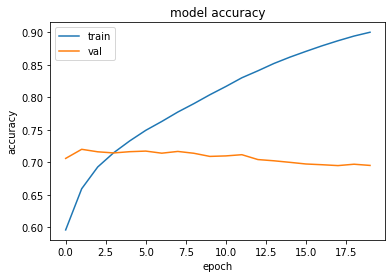

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

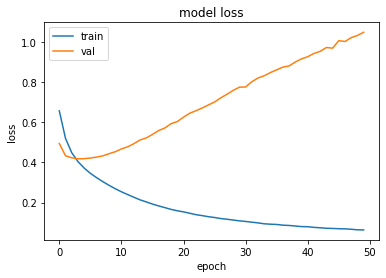

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#automated binomial classification
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import gc
songDirectoriesList = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')

for a in tqdm(range(len(songDirectoriesList))):
    songDirectoriesList = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
    for b in tqdm(range(a+1,len(songDirectoriesList))):
        songDirectoriesList = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
        train_songs = pd.DataFrame()
        test_songs = pd.DataFrame()
        train_labels = []
        test_labels = []
        songDirectories = [songDirectoriesList[a],songDirectoriesList[b]]
        for i in range(0,2):
            temp = pd.read_feather("scaled_data/"+str(songDirectories[i])+"_scaled.feather")
            train_temp = temp.head(temp.shape[0] - temp.shape[0]//6)
            test_temp = temp.tail(temp.shape[0]//6)
            for j in range(train_temp.shape[0]):
                train_labels.append(i)
            for j in range(test_temp.shape[0]):
                test_labels.append(i)
            train_songs = pd.concat([train_songs,train_temp])
            test_songs = pd.concat([test_songs,test_temp])
        del temp,train_temp,test_temp
        gc.collect(generation=2)
        train_songs = train_songs.reset_index(drop=True)
        test_songs = test_songs.reset_index(drop=True)
        test_labels = tf.keras.utils.to_categorical(test_labels)
        test_labels = np.expand_dims(test_labels, 1)
        test_songs = np.expand_dims(test_songs, 1)
        train_labels = tf.keras.utils.to_categorical(train_labels)
        train_labels = np.expand_dims(train_labels, 1)
        train_songs = np.expand_dims(train_songs, 1)

        model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units = 2000,input_shape=(1,4000), return_sequences=True),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.SimpleRNN(units = 1000, input_shape=(1,2000),return_sequences=True),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])
        history = model.fit(train_songs,train_labels,epochs=20,validation_data = (test_songs,test_labels),batch_size=1024)

        np.save('model_results/'+songDirectories[0]+" vs. "+ songDirectories[1]+'.npy',history.history)
        np.save('model_results/'+songDirectories[1]+" vs. "+ songDirectories[0]+'.npy',history.history)

        del model,train_songs,train_labels,test_songs,test_labels,history
        gc.collect(generation=2)
        

<AxesSubplot:>

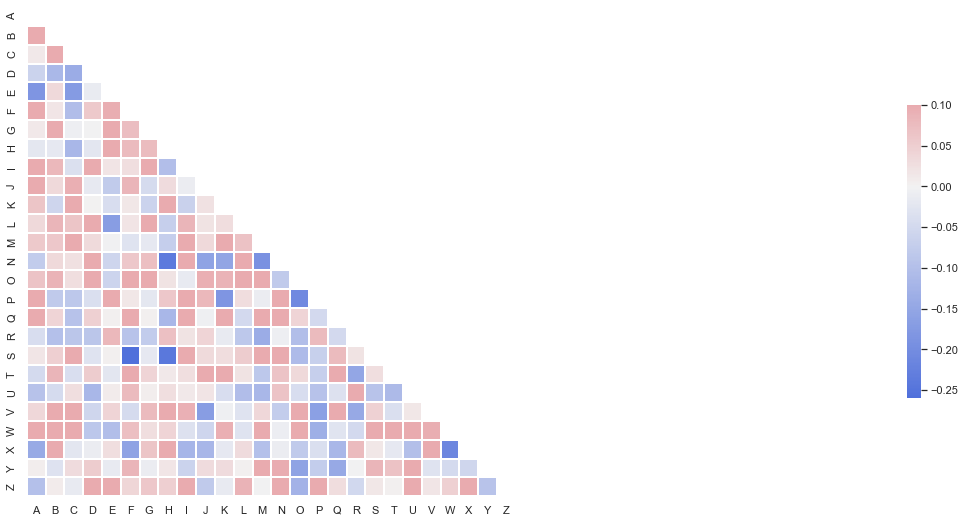

In [45]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(34)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(140, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.1, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .6})

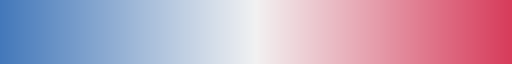

In [64]:
cmap

In [35]:
corr

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
A,1.000000,0.108523,0.011453,-0.062856,-0.183730,0.215167,0.013506,-0.022376,0.156658,0.168149,...,0.162986,-0.043431,0.017562,-0.047993,-0.093815,0.037355,0.141561,-0.142203,0.006606,-0.099563
B,0.108523,1.000000,0.222062,-0.114141,0.033927,0.017047,0.236426,-0.020189,0.080397,0.036264,...,0.041855,-0.098040,0.048072,0.086354,-0.044996,0.221244,0.142560,0.140699,-0.031744,0.008928
C,0.011453,0.222062,1.000000,-0.138377,-0.174228,-0.104436,-0.007419,-0.117465,-0.035990,0.093156,...,-0.094415,-0.087528,0.169026,-0.040456,0.026691,0.100738,0.129649,-0.023847,0.030976,-0.016378
D,-0.062856,-0.114141,-0.138377,1.000000,-0.013178,0.057741,-0.002170,-0.023909,0.175526,-0.017969,...,0.047522,-0.089643,-0.030429,0.053289,-0.116267,-0.056717,-0.086240,-0.010471,0.053099,0.122609
E,-0.183730,0.033927,-0.174228,-0.013178,1.000000,0.096863,0.167177,0.205284,0.019420,-0.077604,...,0.003060,0.082239,0.002792,-0.024592,0.007678,0.039793,-0.102218,0.026359,-0.014890,0.199170
F,0.215167,0.017047,-0.104436,0.057741,0.096863,1.000000,0.074135,0.076426,0.025769,0.086264,...,0.231353,-0.091426,-0.260235,0.137519,0.076567,-0.045879,0.073248,-0.156340,0.085119,0.038327
G,0.013506,0.236426,-0.007419,-0.002170,0.167177,0.074135,1.000000,0.076045,0.118760,-0.045932,...,0.001771,-0.076729,-0.018253,0.040787,0.005898,0.078612,0.026915,0.062339,-0.009805,0.058083
H,-0.022376,-0.020189,-0.117465,-0.023909,0.205284,0.076426,0.076045,1.000000,-0.102384,0.029826,...,-0.117634,0.069504,-0.242265,0.014125,0.027257,0.146095,0.040469,0.192822,0.015702,0.049664
I,0.156658,0.080397,-0.035990,0.175526,0.019420,0.025769,0.118760,-0.102384,1.000000,-0.012395,...,0.161861,0.020386,0.134558,0.027133,0.013871,0.091028,-0.033085,-0.121387,-0.062993,0.102462
J,0.168149,0.036264,0.093156,-0.017969,-0.077604,0.086264,-0.045932,0.029826,-0.012395,1.000000,...,-0.005860,0.040979,0.033810,0.132181,0.019160,-0.169211,-0.058280,-0.118111,0.032386,-0.080490


In [ ]:
songs = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[i])

In [22]:
df = pd.DataFrame(index=genres,columns=genres)

,Alternative,Classical,Country,EDM&Dance,Hyperpop,Jazz,Pop,R&B,Rap,Rock
Alternative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Classical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDM&Dance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hyperpop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jazz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

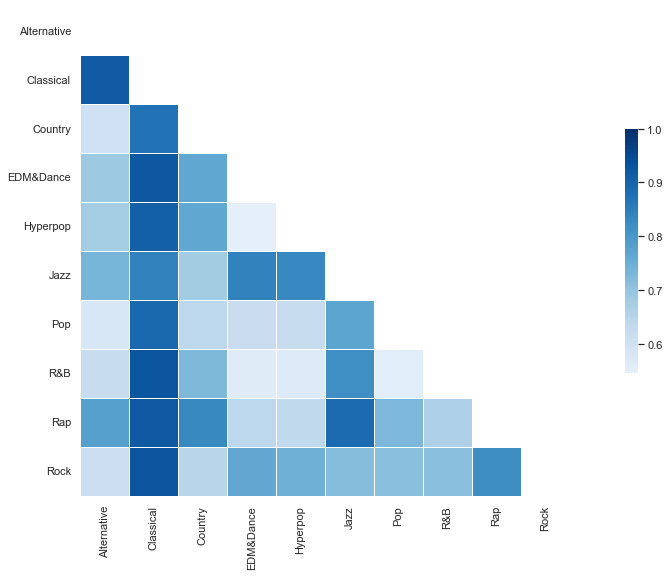

In [71]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
history_list = os.listdir('C:/Users/ritam/DeepLearningNotebooks/model_results')
genres = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
df = pd.DataFrame(index=genres,columns=genres)
for i in range(len(history_list)):
    history = np.load('model_results/'+history_list[i],allow_pickle='TRUE').item()
    compared_genres = history_list[i].split(' vs. ')
    compared_genres[1] = compared_genres[1].replace('.npy','')
    df.at[compared_genres[0],compared_genres[1]] = max(history['val_accuracy'])
    #print(history)
for i in range(len(genres)):
    df.at[genres[i],genres[i]] = float(1)
df = df.apply(pd.to_numeric)


mask = np.triu(np.ones_like(df, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues", as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df, mask=mask, cmap=cmap, vmax=1, center=0.75,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
df

,Alternative,Classical,Country,EDM&Dance,Hyperpop,Jazz,Pop,R&B,Rap,Rock
Alternative,1.000000,0.915280,0.604249,0.690869,0.679705,0.737112,0.579809,0.621986,0.783391,0.610888
Classical,0.915280,1.000000,0.871007,0.922887,0.906189,0.842812,0.889991,0.925702,0.921894,0.925603
Country,0.604249,0.871007,1.000000,0.766331,0.766277,0.681008,0.641477,0.725545,0.828977,0.647384
EDM&Dance,0.690869,0.922887,0.766331,1.000000,0.545689,0.843191,0.616799,0.560563,0.639996,0.764969
Hyperpop,0.679705,0.906189,0.766277,0.545689,1.000000,0.830754,0.623159,0.566095,0.632795,0.744558
Jazz,0.737112,0.842812,0.681008,0.843191,0.830754,1.000000,0.769323,0.817244,0.886723,0.717395
Pop,0.579809,0.889991,0.641477,0.616799,0.623159,0.769323,1.000000,0.557387,0.727829,0.711852
R&B,0.621986,0.925702,0.725545,0.560563,0.566095,0.817244,0.557387,1.000000,0.663457,0.711603
Rap,0.783391,0.921894,0.828977,0.639996,0.632795,0.886723,0.727829,0.663457,1.000000,0.820307
Rock,0.610888,0.925603,0.647384,0.764969,0.744558,0.717395,0.711852,0.711603,0.820307,1.000000


In [1]:
#model 10 class classification
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
songDirectories = os.listdir('C:/Users/ritam/DeepLearningNotebooks/genre datascience')
test_songs = pd.read_feather("training_data_chunks/test.feather")
test_labels = pd.read_feather("training_data_chunks/test_labels.feather")
test_labels = tf.keras.utils.to_categorical(test_labels)
test_labels = np.expand_dims(test_labels, 1)
test_songs = np.expand_dims(test_songs, 1)
train_songs = pd.read_feather("training_data_chunks/part_0.feather")
train_labels = pd.read_feather("training_data_chunks/part_0_labels.feather")
train_labels = tf.keras.utils.to_categorical(train_labels)
train_labels = np.expand_dims(train_labels, 1)
train_songs = np.expand_dims(train_songs, 1)


In [2]:
model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(units = 2500,input_shape=(1,4000), return_sequences=True),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
  ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [3]:
#using feather
def prepare_data(path):
    train_songs = pd.DataFrame()
    train_labels = pd.read_feather("training_data_chunks/"+str(path)+"_labels.feather")
    train_labels = tf.keras.utils.to_categorical(train_labels)
    train_songs = pd.read_feather("training_data_chunks/"+str(path)+".feather")
    #train_songs = pd.read_hdf("training_data_chunks/"+str(path)+".h5", 'df',dtypes=np.float64)
    #train_songs = train_songs.head(train_songs.shape[0])
    train_songs = np.expand_dims(train_songs, 1)
    train_labels = np.expand_dims(train_labels, 1)
    return train_songs,train_labels

In [4]:
def dataGenerator(pathes, batch_size):
    x_train, y_train = 1,1
    while True:
        for path in pathes:
                del x_train
                del y_train
                x_train, y_train = prepare_data(path)

                totalSamps = x_train.shape[0]
                batches = totalSamps // batch_size

                if totalSamps % batch_size > 0:
                    batches+=1

                for batch in range(batches):
                    section = slice(batch*batch_size,(batch+1)*batch_size)
                    
                    yield (x_train[section], y_train[section])        

In [5]:
gen = dataGenerator(['part_0', 'part_1','part_2','part_3','part_4'], 512)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)
#
#history = model.fit(gen,epochs=30,validation_data = (test_songs_final,test_labels_list_final),callbacks=[callback],steps_per_epoch = 1400)
history = model.fit(gen,epochs=20,validation_data = (test_songs,test_labels),steps_per_epoch = 2540,callbacks=[callback])

Epoch 1/20
2540/2540 [==============================] - 128s 48ms/step - loss: 2.5089 - accuracy: 0.1673 - val_loss: 2.2699 - val_accuracy: 0.1750
Epoch 2/20
2540/2540 [==============================] - 92s 36ms/step - loss: 2.2805 - accuracy: 0.1766 - val_loss: 2.1980 - val_accuracy: 0.2040
Epoch 3/20
2540/2540 [==============================] - 89s 35ms/step - loss: 2.2106 - accuracy: 0.2168 - val_loss: 2.1147 - val_accuracy: 0.2104
Epoch 4/20
2540/2540 [==============================] - 89s 35ms/step - loss: 2.1717 - accuracy: 0.2229 - val_loss: 2.0673 - val_accuracy: 0.2391
Epoch 5/20
2540/2540 [==============================] - 82s 32ms/step - loss: 2.1523 - accuracy: 0.2165 - val_loss: 2.0725 - val_accuracy: 0.2331
Epoch 6/20
2540/2540 [==============================] - 89s 35ms/step - loss: 2.1217 - accuracy: 0.2230 - val_loss: 2.0410 - val_accuracy: 0.2413
Epoch 7/20
2540/2540 [==============================] - 91s 36ms/step - loss: 2.0959 - accuracy: 0.2268 - val_loss: 2.0187 

In [ ]:
history = model.fit(train_songs,train_labels,epochs=30,validation_data = (test_songs,test_labels),batch_size=512)

Epoch 1/30
518/518 [==============================] - 11s 17ms/step - loss: 2.4651 - accuracy: 0.1205 - val_loss: 2.2683 - val_accuracy: 0.1584
Epoch 2/30
518/518 [==============================] - 6s 12ms/step - loss: 2.2823 - accuracy: 0.1455 - val_loss: 2.2562 - val_accuracy: 0.1743
Epoch 3/30
518/518 [==============================] - 6s 12ms/step - loss: 2.2449 - accuracy: 0.1645 - val_loss: 2.2198 - val_accuracy: 0.1911
Epoch 4/30
518/518 [==============================] - 6s 12ms/step - loss: 2.1953 - accuracy: 0.1911 - val_loss: 2.1458 - val_accuracy: 0.2256
Epoch 5/30
518/518 [==============================] - 6s 12ms/step - loss: 2.1248 - accuracy: 0.2242 - val_loss: 2.0792 - val_accuracy: 0.2443
Epoch 6/30
518/518 [==============================] - 6s 12ms/step - loss: 2.0695 - accuracy: 0.2471 - val_loss: 2.0511 - val_accuracy: 0.2504
Epoch 7/30
518/518 [==============================] - 6s 12ms/step - loss: 2.0310 - accuracy: 0.2636 - val_loss: 2.0338 - val_accuracy: 0.255

In [3]:
print(train_songs.shape)

(264934, 1, 4000)


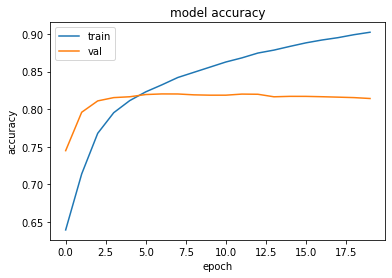

In [5]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


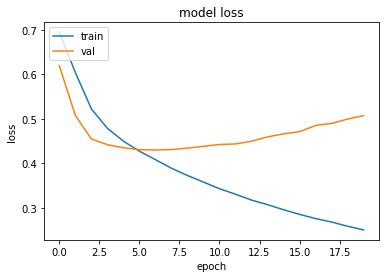

In [6]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
print(train_songs.shape)

(264934, 1, 4000)


In [8]:
print(train_songs[0].shape)

(1, 4000)


In [20]:
flattened_data = train_songs[60000].reshape(-1)

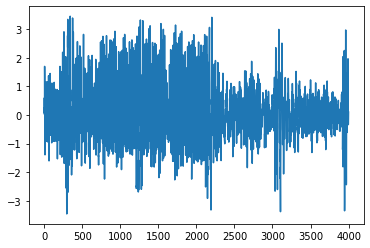

In [21]:
#print(flattened_data.shape)
plt.plot(flattened_data)

In [5]:
alternative = pd.read_feather("training_data/Alternative.feather")
#alternative = alternative.values.reshape(-1)
alternative = alternative.transpose()

In [27]:
rock = pd.read_feather("training_data/Rock.feather")
rock = rock.transpose()

In [28]:
rock_data = rock.describe()

In [7]:
alt_data = alternative.describe()

In [13]:
alt_data

,0,1,2,3,4,5,6,7,8,9,...,130238,130239,130240,130241,130242,130243,130244,130245,130246,130247
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.884825,-0.073350,2.743513,1.302763,1.087300,0.971362,0.027912,-1.185413,2.775300,0.774512,...,-0.456037,-0.44050,0.131175,0.414362,-0.174550,0.128000,-0.307900,-0.218100,0.029738,0.023938
std,209.032390,239.011831,1111.589789,1439.386670,1291.023299,1649.778532,1819.726546,2223.201212,3857.631261,4630.895857,...,2387.397889,2521.77662,2523.026906,2087.335760,2038.788552,1531.205328,727.233983,583.095187,11.998478,11.119359
min,-902.800000,-1046.300000,-4553.350000,-5883.350000,-4980.500000,-5825.700000,-6905.400000,-8317.300000,-13028.000000,-16345.500000,...,-10024.150000,-9054.15000,-9711.800000,-10678.800000,-8213.400000,-6349.150000,-3730.850000,-2940.450000,-53.150000,-52.750000
25%,-119.525000,-135.025000,-613.262500,-701.012500,-854.950000,-1049.987500,-1129.312500,-1373.462500,-2485.925000,-2943.950000,...,-1522.587500,-1732.76250,-1584.687500,-1388.700000,-1363.112500,-978.962500,-297.462500,-220.062500,-4.750000,-4.800000
50%,0.000000,0.050000,21.575000,26.825000,46.425000,59.625000,69.150000,48.975000,-100.150000,-29.400000,...,-57.000000,-66.02500,-24.625000,-51.900000,35.275000,-17.350000,-4.275000,-7.675000,0.000000,0.000000
75%,126.500000,147.562500,720.662500,800.950000,897.600000,1101.012500,1210.037500,1438.950000,2290.762500,2745.212500,...,1512.550000,1698.23750,1495.825000,1345.950000,1321.237500,921.062500,302.100000,228.137500,4.700000,4.750000
max,749.600000,834.850000,3814.350000,5666.400000,4970.200000,5678.400000,6384.650000,9095.700000,12766.300000,16052.900000,...,10226.800000,9213.30000,11545.300000,8546.750000,8081.650000,6178.000000,3466.350000,3350.850000,55.650000,51.700000


In [25]:
data = alt_data.iloc[:,::500]#.boxplot()

In [29]:
rock_box = rock_data.iloc[:,::500]

<AxesSubplot:>

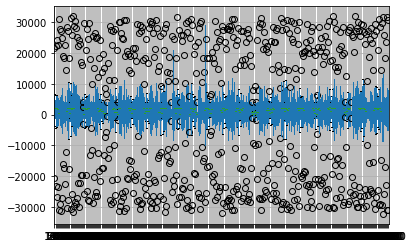

In [30]:
rock_box.boxplot()

<AxesSubplot:>

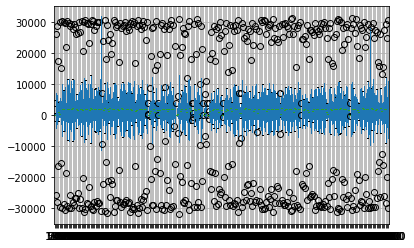

In [26]:
data.boxplot()

In [18]:
#print(train_labels.shape)
print(test_labels_list_final.shape)
#print(train_songs.shape)
print(test_songs_final.shape)

(20000, 1, 10)
(20000, 1, 10000)


In [2]:
for k in range(0,5):
        train_songs = pd.DataFrame()
        train_labels_list = []
        for i in tqdm(range(0,10)):
                #for loop, reads data, splits into testing set and training set, makes labels, and concat to main dataframe
                dftemp = pd.read_feather("scaled_data_v2/"+str(songDirectories[i])+"_scaled.feather")
                df_train = dftemp.head(dftemp.shape[0]-dftemp.shape[0]//20)
                df_train = df_train.truncate(before = 1+k*(df_train.shape[0]//5),after=(k+1)*df_train.shape[0]//5)
                train_songs = pd.concat([train_songs,df_train])
                for j in range(df_train.shape[0]):
                        train_labels_list.append(i)
                del dftemp
                del df_train
        train_labels = pd.DataFrame(train_labels_list)
        train_songs = train_songs.reset_index(drop=True)
        train_labels = train_labels.reset_index(drop=True)
        train_songs.columns = train_songs.columns.astype(str)
        train_labels.columns = train_labels.columns.astype(str)
        train_songs.to_feather("training_data_chunks_v2/part_"+str(k)+".feather")
        train_labels.to_feather("training_data_chunks_v2/part_"+str(k)+"_labels.feather")

100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


In [3]:
train_songs = pd.DataFrame()
train_labels_list = []
for i in tqdm(range(0,10)):
        #for loop, reads data, splits into testing set and training set, makes labels, and concat to main dataframe
        dftemp = pd.read_feather("scaled_data_v2/"+str(songDirectories[i])+"_scaled.feather")
        df_train = dftemp.tail(dftemp.shape[0]//20)
        train_songs = pd.concat([train_songs,df_train])
        for j in range(df_train.shape[0]):
                train_labels_list.append(i)
        del dftemp
        del df_train
train_labels = pd.DataFrame(train_labels_list)
train_songs = train_songs.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
train_songs.columns = train_songs.columns.astype(str)
train_labels.columns = train_labels.columns.astype(str)
train_songs.to_feather("training_data_chunks_v2/test.feather")
train_labels.to_feather("training_data_chunks_v2/test_labels.feather")

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


In [6]:
model.save('training_models/model_save')

INFO:tensorflow:Assets written to: training_models/model_save\assets


In [16]:
model.evaluate(test_songs,test_labels,batch_size=256)

59/59 [==============================] - 1s 10ms/step - loss: 3.3825 - accuracy: 0.2157


[3.382521390914917, 0.21566666662693024]

In [5]:
#print(train_labels.shape)
print(test_labels.shape)
#print(train_songs.shape)
print(test_songs.shape)

(20000, 1, 10)
(20000, 1, 10000)


In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
model = tf.keras.models.load_model('training_models/model_save')

In [7]:
model.save('training_models/model_save_3')

INFO:tensorflow:Assets written to: training_models/model_save_3\assets


In [61]:
time=120
sr, song = read('C:/Users/ritam/DeepLearningNotebooks/genre datascience'+'/'+songDirectories[0]+'/Clairo - 02 - Amoeba.mp3')
song = song /2.0**15
sound = song[:sr*time]

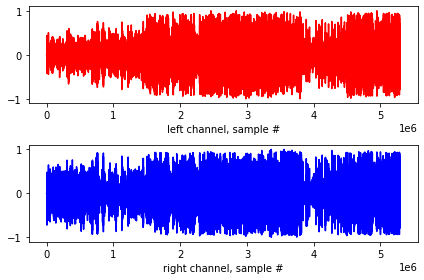

In [62]:
from matplotlib import pyplot as plt
plt.subplot(2,1,1)
plt.plot(sound[:,0], 'r')
plt.xlabel("left channel, sample #")
plt.subplot(2,1,2)
plt.plot(sound[:,1], 'b')
plt.xlabel("right channel, sample #")
plt.tight_layout()
plt.show()

In [63]:
signal = sound[:,0]
length_in_s = sound.shape[0] / sr
time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s

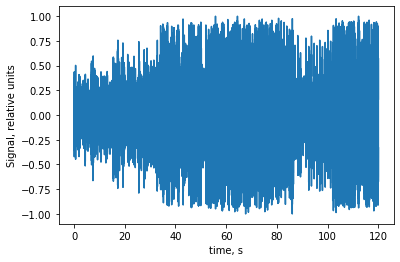

In [64]:
plt.plot(time, signal)
plt.xlabel("time, s")
plt.ylabel("Signal, relative units")
plt.show()

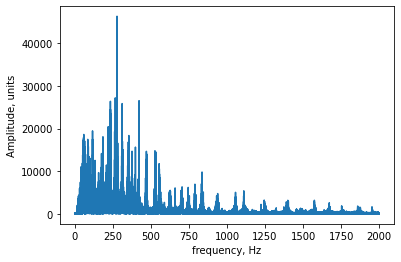

In [79]:
fft_spectrum = np.fft.rfft(signal)
freq = np.fft.rfftfreq(signal.size, d=1./sr)
fft_spectrum_abs = np.abs(fft_spectrum)
for i in range(len(freq)):
    if(freq[i] >= 2000):
        index = i
        break
plt.plot(freq[:index], fft_spectrum_abs[:index])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

In [81]:
for i,f in enumerate(fft_spectrum_abs):
    if f > 20000 and (freq[i] < 2000): #looking at amplitudes of the spikes higher than 350 
        print('frequency = {} Hz with amplitude {} '.format(np.round(freq[i],1),  np.round(f)))

frequency = 219.7 Hz with amplitude 20446.0 
frequency = 233.6 Hz with amplitude 20330.0 
frequency = 234.0 Hz with amplitude 26393.0 
frequency = 234.4 Hz with amplitude 20557.0 
frequency = 234.5 Hz with amplitude 24496.0 
frequency = 234.6 Hz with amplitude 21540.0 
frequency = 235.1 Hz with amplitude 23592.0 
frequency = 235.2 Hz with amplitude 20834.0 
frequency = 235.3 Hz with amplitude 23001.0 
frequency = 235.4 Hz with amplitude 21918.0 
frequency = 237.1 Hz with amplitude 21815.0 
frequency = 237.3 Hz with amplitude 21940.0 
frequency = 237.4 Hz with amplitude 20232.0 
frequency = 266.1 Hz with amplitude 27198.0 
frequency = 276.9 Hz with amplitude 26313.0 
frequency = 277.1 Hz with amplitude 20155.0 
frequency = 277.2 Hz with amplitude 23141.0 
frequency = 277.2 Hz with amplitude 20340.0 
frequency = 277.2 Hz with amplitude 24419.0 
frequency = 277.2 Hz with amplitude 28496.0 
frequency = 277.5 Hz with amplitude 46334.0 
frequency = 277.5 Hz with amplitude 24220.0 
frequency 